In [2]:
import pandas as pd
import numpy as np
import shap
import lime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from lime import lime_tabular 
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score,precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import lime.lime_tabular
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv('/Users/ven/Documents/ven/t2b/t2/t2/term-deposit-marketing-2020.csv')
# Display the first few rows of the dataset for an overview
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000


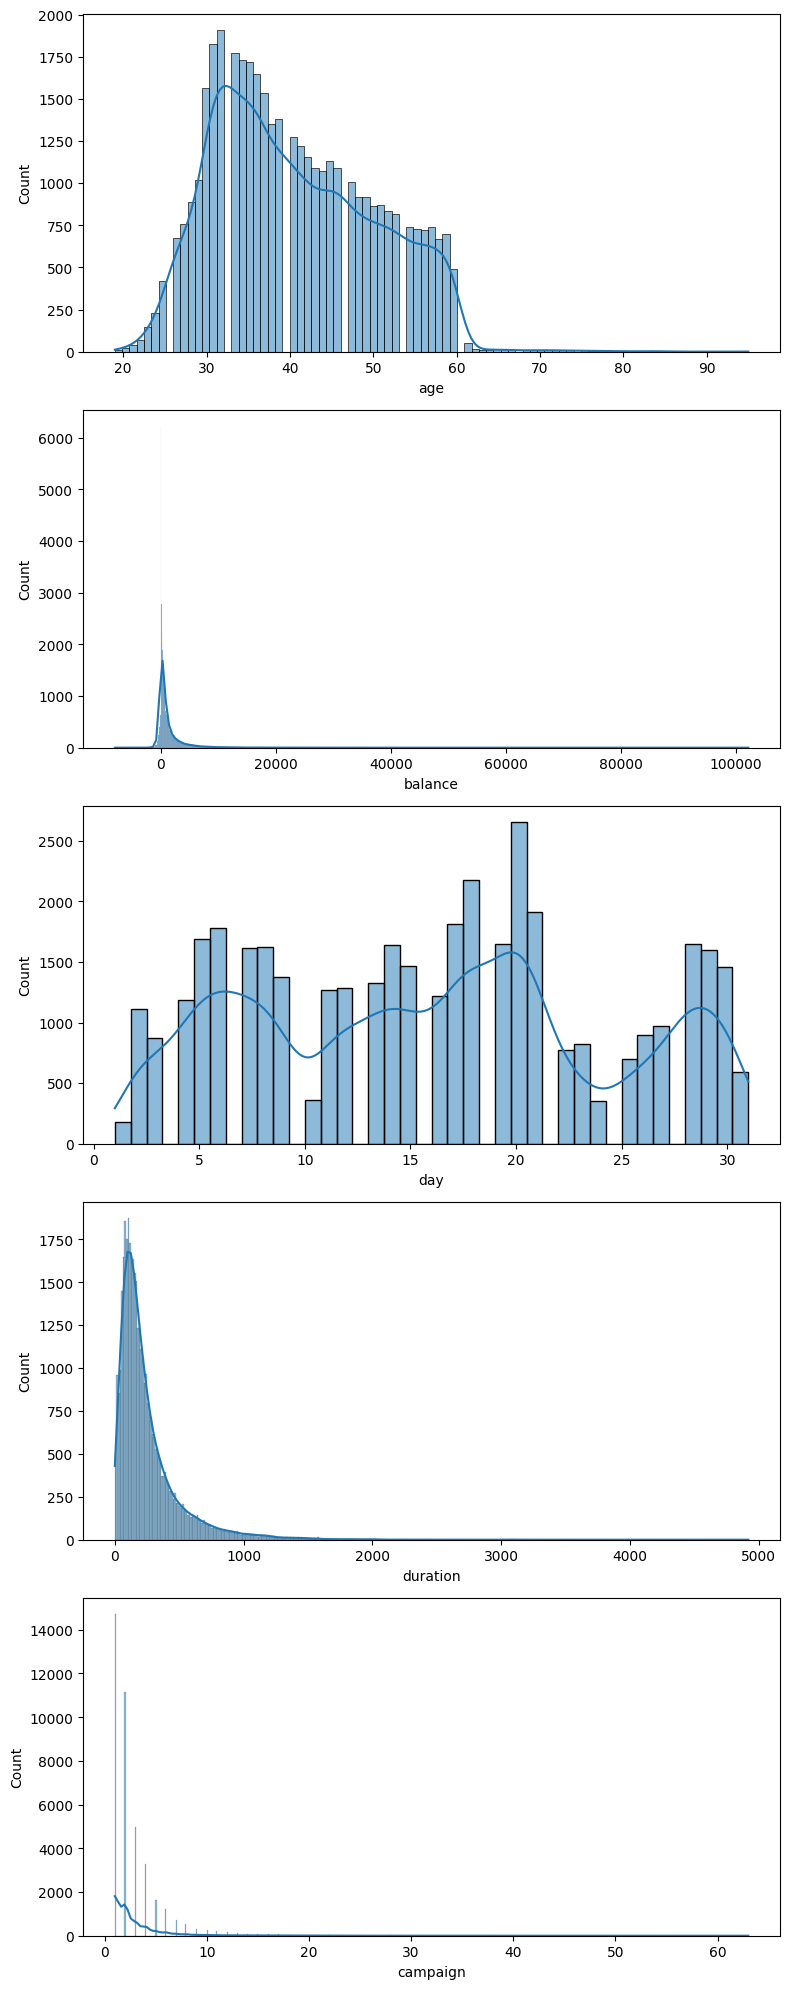

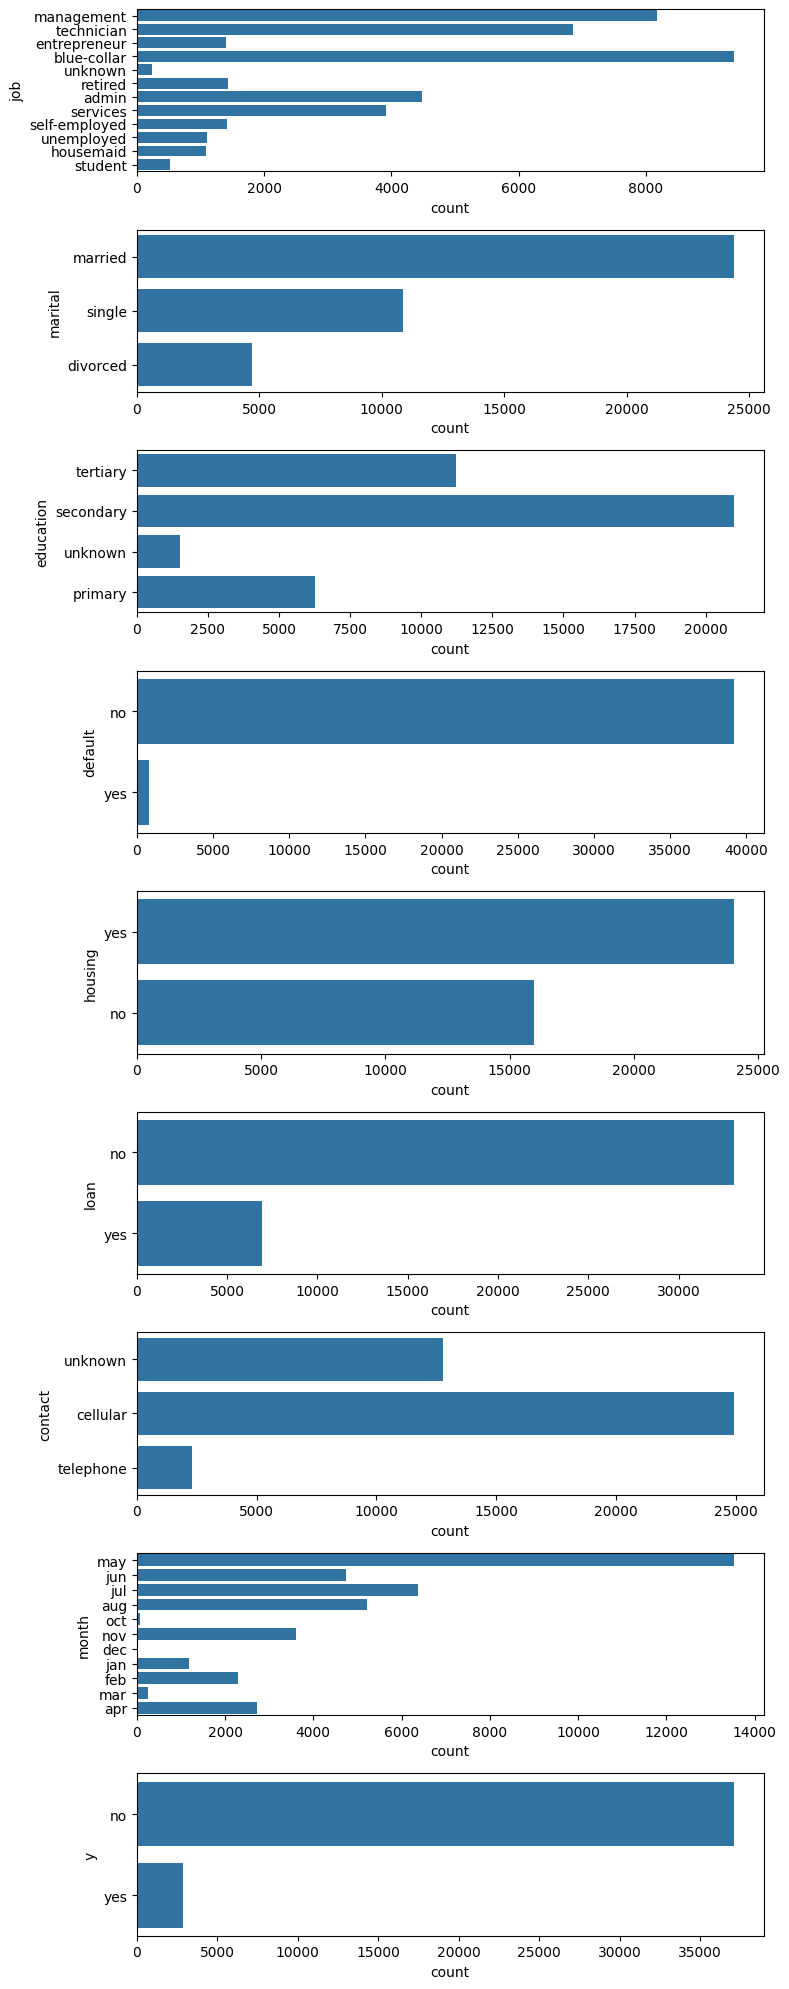

In [3]:
# Split the data into features and target variable
X = data.drop('y', axis=1)  # Replace 'target_column_name' with the name of your target column
y = data['y']

# Summary statistics
print(data.describe())

# Distribution of numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64'])
fig, ax = plt.subplots(len(numerical_features.columns), 1, figsize=(8, 20))
for i, col in enumerate(numerical_features.columns):
    sns.histplot(numerical_features[col], kde=True, ax=ax[i])
plt.tight_layout()
plt.show()

# Distribution of categorical features
categorical_features = data.select_dtypes(include=['object'])
fig, ax = plt.subplots(len(categorical_features.columns), 1, figsize=(8, 20))
for i, col in enumerate(categorical_features.columns):
    sns.countplot(y=categorical_features[col], ax=ax[i])
plt.tight_layout()
plt.show()


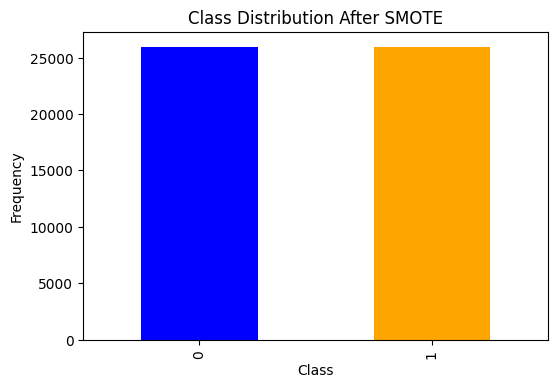

In [4]:
# Addressing class imbalance with SMOTE
smote = SMOTE(random_state=42)

# Check if 'y' column exists
if 'y' not in data.columns:
    raise ValueError("Column 'y' does not exist in the dataset.")

# Separate target variable
y = data['y'].map({'yes': 1, 'no': 0})  # Convert the target variable 'y' to binary format
X = data.drop('y', axis=1)

# Identify and one-hot encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#encoder = OneHotEncoder(handle_unknown='ignore')
#encoder = OneHotEncoder(sparse=False)
encoded_data = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
encoded_data.columns = encoder.get_feature_names_out(categorical_cols)

# Merge with original data
X_encoded = X.drop(categorical_cols, axis=1)
X_encoded = pd.concat([X_encoded, encoded_data], axis=1)
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize class imbalance after SMOTE
plt.figure(figsize=(6, 4))
pd.Series(y_train_resampled).value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [5]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Average performance score
average_cv_score = np.mean(cv_scores)

print ('average CV score', average_cv_score)

average CV score 0.9348928571428571


Average CV score: 0.9348928571428571
Test Accuracy: 0.9333333333333333


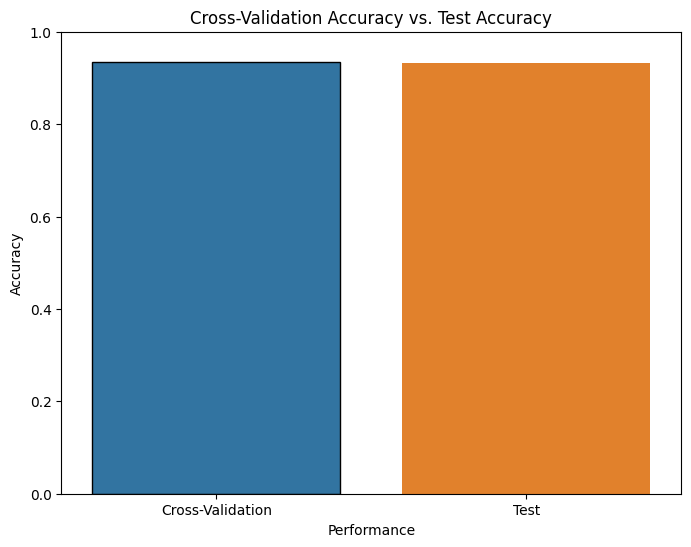

In [6]:
#Fit the model on the training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set and calculate accuracy
y_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print('Average CV score:', average_cv_score)
print('Test Accuracy:', test_accuracy)
# Define the colors for cross-validation and test accuracy bars
colors = ['#1f77b4', '#ff7f0e']

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=['Cross-Validation', 'Test'], y=[average_cv_score, test_accuracy], palette=colors)

# Add a separating line between bars
for i, p in enumerate(ax.patches):
    if i % 2 == 0:
        p.set_edgecolor('#000000')  # Set the separating line color for CV accuracy

# Customize the plot
plt.title('Cross-Validation Accuracy vs. Test Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Performance')

# Show the plot
plt.show()

In [7]:
# Check if 'y' column exists
if 'y' not in data.columns:
    raise ValueError("Column 'y' does not exist in the dataset.")

# Separate target variable
#y = data['y'].map({'yes': 1, 'no': 0})  # Convert the target variable 'y' to binary format
X = data.drop('y', axis=1)
# Identify categorical columns (this needs to be customized based on your dataset)

# Identify and one-hot encode categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'), categorical_columns)], remainder='passthrough')
X = preprocessor.fit_transform(data.drop('y', axis=1))
y = data['y']
y = data['y'].map({'yes': 1, 'no': 0}) 
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
def calculate_f1_scores_for_thresholds(model, X, y_true, thresholds):
    probas_ = model.predict_proba(X)[:, 1]
    f1_scores = [f1_score(y_true, probas_ >= threshold) for threshold in thresholds]
    return f1_scores

def tune_and_evaluate_with_thresholds(model, param_grid, X_train, y_train, X_test, y_test, thresholds):
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    f1_scores = calculate_f1_scores_for_thresholds(best_model, X_test, y_test, thresholds)
    return best_model, thresholds, f1_scores

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

thresholds = np.linspace(0.1, 0.9, 9)
model_f1_scores = {}

for name, model in models.items():
    _, thresholds, f1_scores = tune_and_evaluate_with_thresholds(model, param_grids[name], X_train, y_train, X_test, y_test, thresholds)
    model_f1_scores[name] = f1_scores

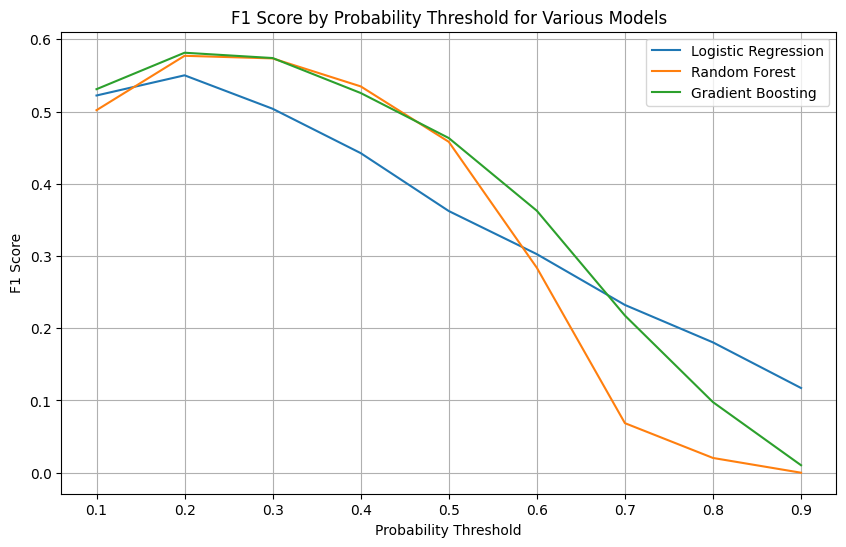

In [11]:
plt.figure(figsize=(10, 6))

for name, f1_scores in model_f1_scores.items():
    plt.plot(thresholds, f1_scores, label=name)

plt.title('F1 Score by Probability Threshold for Various Models')
plt.xlabel('Probability Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

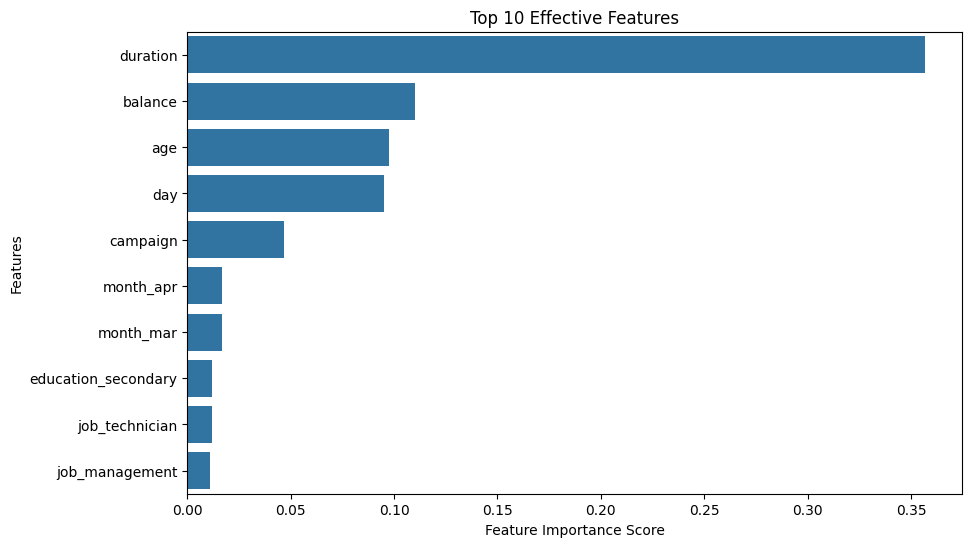

In [7]:
# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Plot feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
top_features = feature_importances.nlargest(10)  # Top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 10 Effective Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()


100%|===================| 55994/56000 [25:55<00:00]        

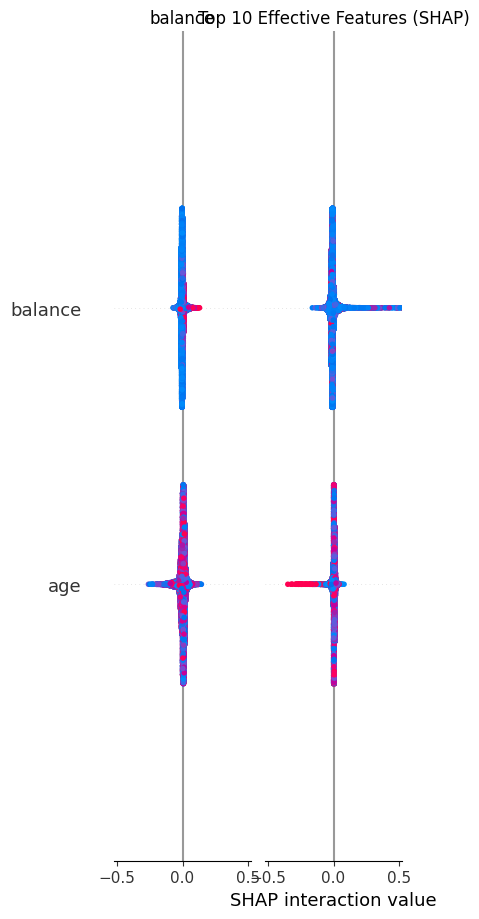

In [9]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(clf, X_train)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10, show=False)
plt.title('Top Effective Features (SHAP)')
plt.show()


In [11]:
# Assuming 'best_features' is a list of the top feature names identified from SHAP and LIME analyses
best_features = ['duration', 'balance','age', 'day', 'campaign','month']

# Check if 'y' column exists
if 'y' not in data.columns:
    raise ValueError("Column 'y' does not exist in the dataset.")

# Separate target variable
y = data['y'].map({'yes': 1, 'no': 0})  # Convert the target variable 'y' to binary format

# Keep only the best features in X
X = data[best_features]

# Since we're now working with a reduced set of features, some of which may be categorical,
# identify which of the best features are categorical
categorical_columns = [col for col in best_features if data[col].dtype == 'object']

# Apply one-hot encoding only to the identified best categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ], 
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    "Gradient Boosting": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}

thresholds = np.linspace(0.1, 0.9, 9)
model_f1_scores = {}

for name, model in models.items():
    _, thresholds, f1_scores = tune_and_evaluate_with_thresholds(model, param_grids[name], X_train, y_train, X_test, y_test, thresholds)
    model_f1_scores[name] = f1_scores

In [15]:
for name, model in models.items():
    _, _, f1_scores = tune_and_evaluate_with_thresholds(model, param_grids[name], X_train, y_train, X_test, y_test, thresholds)
    model_f1_scores[name] = f1_scores
    
    # Print F1 scores for each model
    print(f"F1 Scores for {name}:")
    for i, f1_score_value in enumerate(f1_scores):
        print(f"Threshold: {thresholds[i]}, F1 Score: {f1_score_value}")
    print()

F1 Scores for Logistic Regression:
Threshold: 0.1, F1 Score: 0.4925883694412771
Threshold: 0.2, F1 Score: 0.5020441537203598
Threshold: 0.30000000000000004, F1 Score: 0.48316831683168315
Threshold: 0.4, F1 Score: 0.42424242424242425
Threshold: 0.5, F1 Score: 0.349009900990099
Threshold: 0.6, F1 Score: 0.2784471218206158
Threshold: 0.7000000000000001, F1 Score: 0.21233859397417504
Threshold: 0.8, F1 Score: 0.1519756838905775
Threshold: 0.9, F1 Score: 0.0932475884244373

F1 Scores for Random Forest:
Threshold: 0.1, F1 Score: 0.5002521432173475
Threshold: 0.2, F1 Score: 0.5554089709762533
Threshold: 0.30000000000000004, F1 Score: 0.5517241379310345
Threshold: 0.4, F1 Score: 0.5298988040478381
Threshold: 0.5, F1 Score: 0.4432314410480349
Threshold: 0.6, F1 Score: 0.296
Threshold: 0.7000000000000001, F1 Score: 0.13793103448275862
Threshold: 0.8, F1 Score: 0.037162162162162164
Threshold: 0.9, F1 Score: 0.0

F1 Scores for Gradient Boosting:
Threshold: 0.1, F1 Score: 0.5145046524356869
Thresho

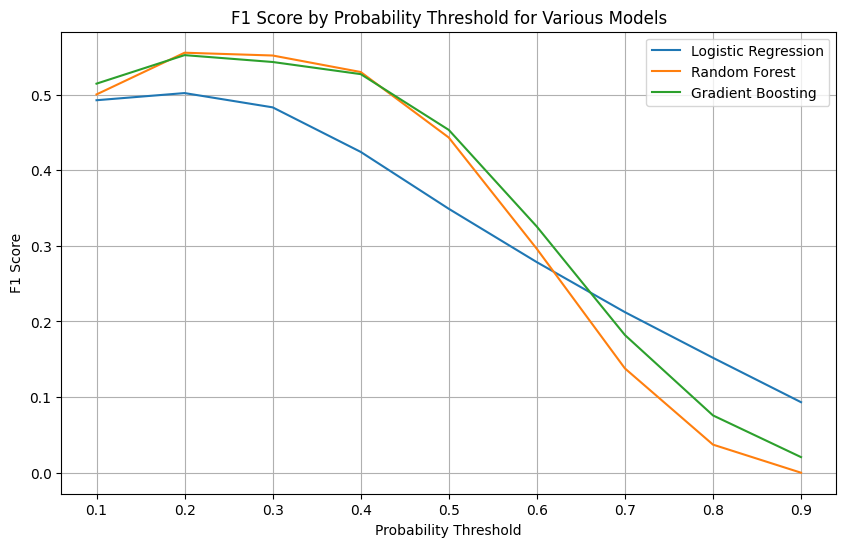

In [16]:
plt.figure(figsize=(10, 6))

for name, f1_scores in model_f1_scores.items():
    plt.plot(thresholds, f1_scores, label=name)

plt.title('F1 Score by Probability Threshold for Various Models')
plt.xlabel('Probability Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()